# 4.AutoEncoder: Comparative Analysis

## 4.2.CNN AutoEncoder

### 4.2.1.Dataset Analysis and Preprocessing

In [1]:
import idx2numpy
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [74]:
train_images = idx2numpy.convert_from_file('../../data/external/fashion_mnist/train-images-idx3-ubyte')
train_labels = idx2numpy.convert_from_file('../../data/external/fashion_mnist/train-labels-idx1-ubyte')
test_images = idx2numpy.convert_from_file('../../data/external/fashion_mnist/t10k-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file('../../data/external/fashion_mnist/t10k-labels-idx1-ubyte')


In [3]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = FashionMNISTDataset(train_images, train_labels, transform=transform)
test_dataset = FashionMNISTDataset(test_images, test_labels, transform=transform)


In [5]:
train_size = int(0.8 * len(train_dataset))
val_size = int(0.2 * len(train_dataset))

train_set, val_set = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


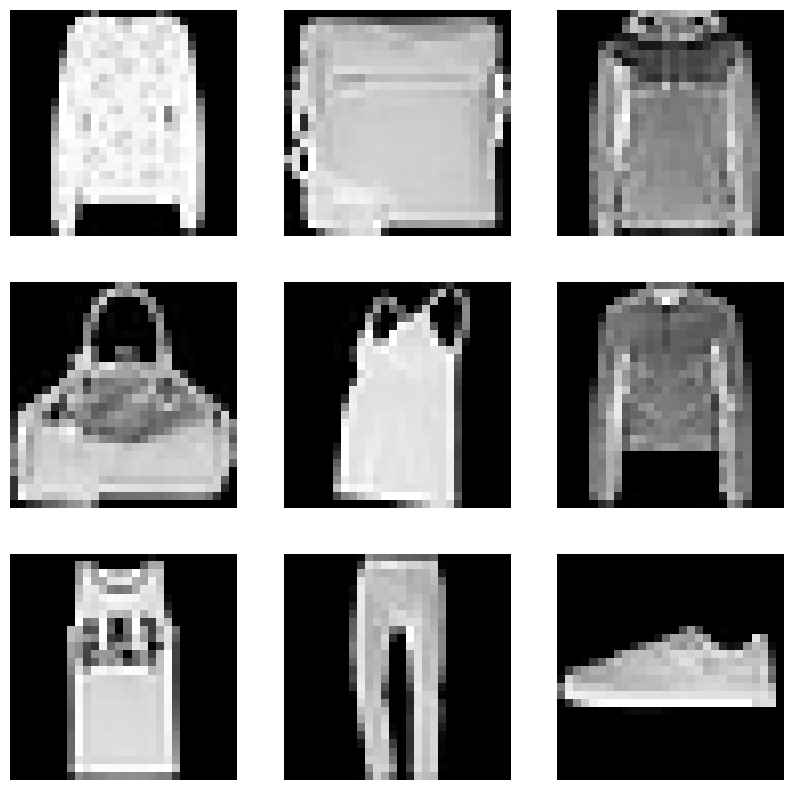

In [6]:
def show_images(images):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images[:9]
labels = labels[:9]

show_images(images)


class labels = T-shirt/top, Trouser, Pullover, Dress, Jacket,Sandal, Shirt, Sneaker, Hand Bag, Boot

In [7]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Jacket",
    "Sandal", "Shirt", "Sneaker", "Hand Bag", "Boot"
]

### 4.2.2.Implement the CnnAutoencoder class

In [8]:
import sys
sys.path.append("../..")

import models.AutoEncoders.cnn_autoencoder as cnn_autoencoder

### 4.2.3.Plots and Visualizations

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [10]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
model = cnn_autoencoder.CnnAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 5
for epoch in range(n_epochs):
    for images, _ in train_loader:
        images = images.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")


Epoch [1/5], Loss: 1.0976
Epoch [2/5], Loss: 0.8783
Epoch [3/5], Loss: 0.7673
Epoch [4/5], Loss: 0.7245
Epoch [5/5], Loss: 0.6753


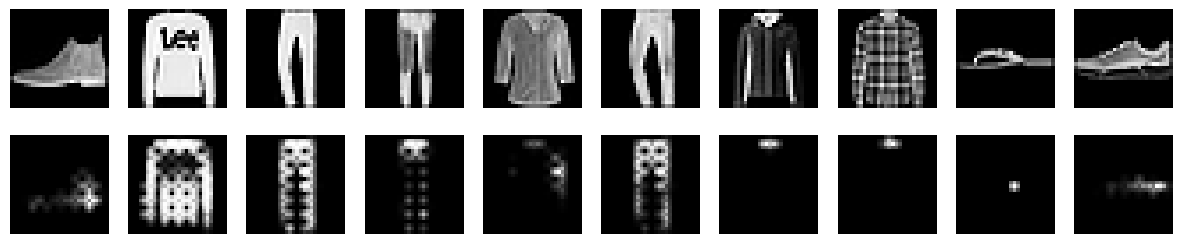

In [12]:
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)

reconstructed = model(images)

reconstructed = reconstructed.cpu().detach()

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(reconstructed[i].squeeze().numpy(), cmap='gray')
    axes[1, i].axis('off')
plt.show()

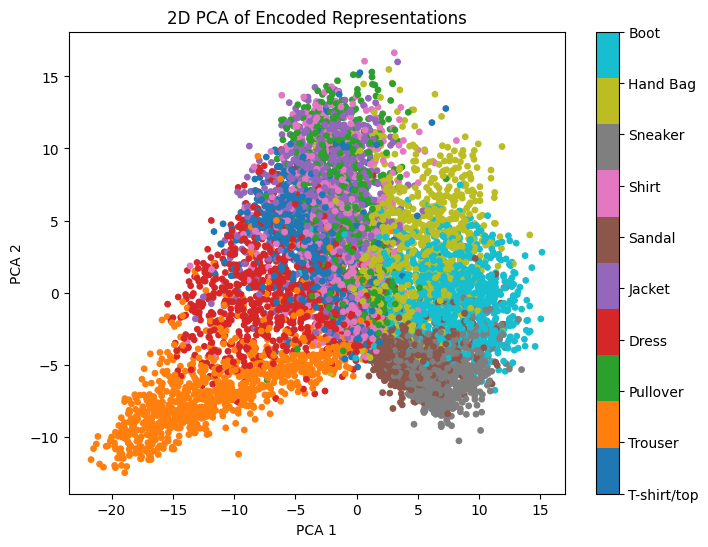

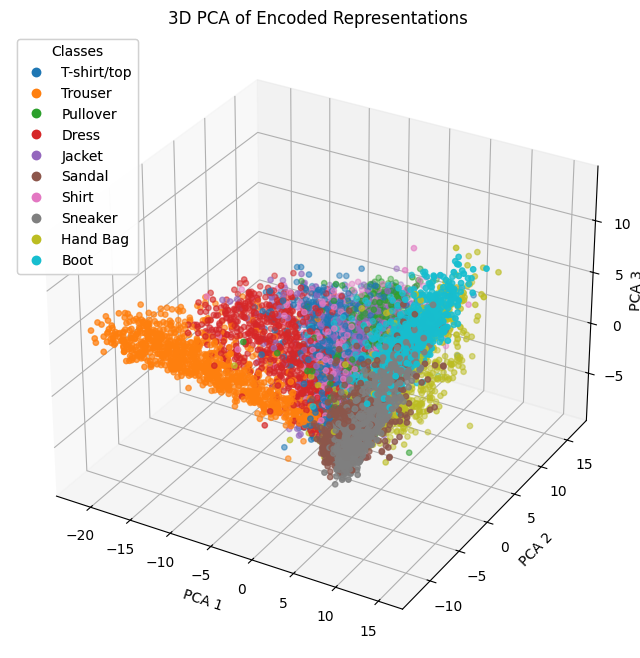

In [13]:
encoded_representations = []
labels = []

with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        
        encoded = model.encode(images)
        
        encoded = encoded.view(encoded.size(0), -1)
        encoded_representations.append(encoded.cpu())
        
        labels.extend(label.numpy())

encoded_representations = torch.cat(encoded_representations).numpy()



pca_2d = PCA(n_components=2)
encoded_2d = pca_2d.fit_transform(encoded_representations)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=labels, cmap='tab10', s=15)

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(class_names)))
cbar.set_ticklabels(class_names)

plt.title('2D PCA of Encoded Representations')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()



pca_3d = PCA(n_components=3)
encoded_3d = pca_3d.fit_transform(encoded_representations)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(encoded_3d[:, 0], encoded_3d[:, 1], encoded_3d[:, 2], c=labels, cmap='tab10', s=15)

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Classes")
ax.add_artist(legend1)

ax.set_title('3D PCA of Encoded Representations')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3', labelpad=-1)
plt.show()


The PCA visualizations show distinct clustering patterns for different labels, with some overlap between clusters. 

### 4.2.4.Hyperparameter Tuning

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


Training Configuration 1: {'lr': 0.001, 'kernel_size': 3, 'optimizer': 'Adam'}
Epoch [1/10], Train Loss: 0.8252, Validation Loss: 0.6621
Epoch [2/10], Train Loss: 0.6601, Validation Loss: 0.6562
Epoch [3/10], Train Loss: 0.6367, Validation Loss: 0.6255
Epoch [4/10], Train Loss: 0.6242, Validation Loss: 0.6198
Epoch [5/10], Train Loss: 0.6191, Validation Loss: 0.6156
Epoch [6/10], Train Loss: 0.6158, Validation Loss: 0.6132
Epoch [7/10], Train Loss: 0.6138, Validation Loss: 0.6114
Epoch [8/10], Train Loss: 0.6127, Validation Loss: 0.6105
Epoch [9/10], Train Loss: 0.6118, Validation Loss: 0.6098
Epoch [10/10], Train Loss: 0.6111, Validation Loss: 0.6091


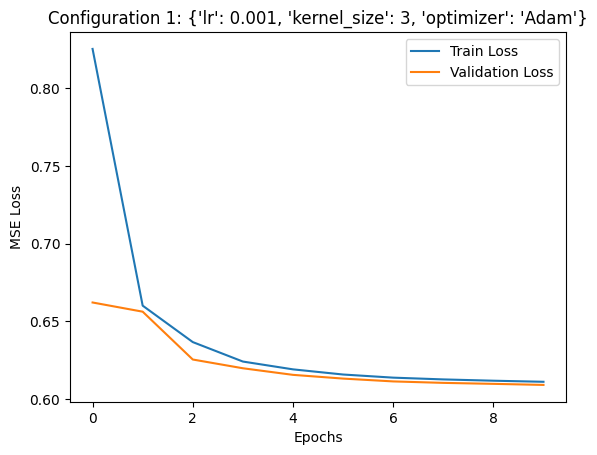


Training Configuration 2: {'lr': 0.0005, 'kernel_size': 5, 'optimizer': 'RMSprop'}
Epoch [1/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [2/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [3/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [4/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [5/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [6/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [7/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [8/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [9/10], Train Loss: 1.3849, Validation Loss: 1.3816
Epoch [10/10], Train Loss: 1.3849, Validation Loss: 1.3816


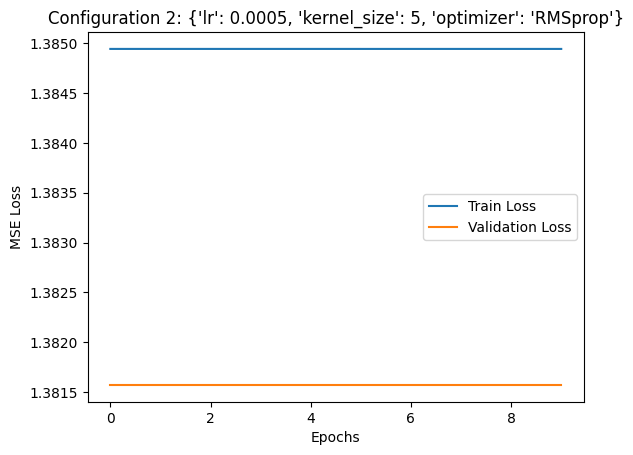


Training Configuration 3: {'lr': 0.001, 'kernel_size': 3, 'optimizer': 'SGD'}
Epoch [1/10], Train Loss: 1.3030, Validation Loss: 1.2247
Epoch [2/10], Train Loss: 1.1645, Validation Loss: 1.1048
Epoch [3/10], Train Loss: 1.0610, Validation Loss: 1.0171
Epoch [4/10], Train Loss: 0.9857, Validation Loss: 0.9536
Epoch [5/10], Train Loss: 0.9310, Validation Loss: 0.9070
Epoch [6/10], Train Loss: 0.8904, Validation Loss: 0.8721
Epoch [7/10], Train Loss: 0.8596, Validation Loss: 0.8453
Epoch [8/10], Train Loss: 0.8358, Validation Loss: 0.8243
Epoch [9/10], Train Loss: 0.8169, Validation Loss: 0.8075
Epoch [10/10], Train Loss: 0.8017, Validation Loss: 0.7938


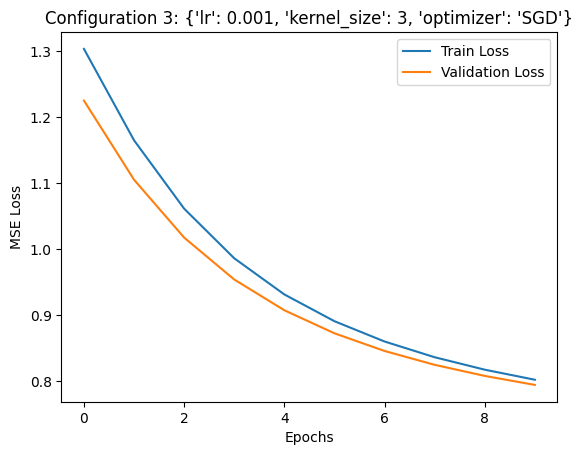

In [15]:
configs = [
    {"lr": 0.001, "kernel_size": 3, "optimizer": "Adam"},
    {"lr": 0.0005, "kernel_size": 5, "optimizer": "RMSprop"},
    {"lr": 0.001, "kernel_size": 3, "optimizer": "SGD"}
]

for idx, config in enumerate(configs):
    print(f"\nTraining Configuration {idx+1}: {config}")

    model = cnn_autoencoder.CnnAutoencoder(kernel_size=config["kernel_size"]).to(device)
    criterion = nn.MSELoss()
    
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"])

    n_epochs = 10
    train_loss = []
    val_loss = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                val_loss_batch = criterion(outputs, images)
                running_val_loss += val_loss_batch.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)
        
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title(f"Configuration {idx+1}: {config}")
    plt.legend()
    plt.show()

Best model (among the 3) based on MSE loss : {'lr': 0.001, 'kernel_size': 3, 'optimizer': 'Adam'}

## 4.3.MLP Autoencoder

In [16]:
import sys
sys.path.append("../..")

import models.AutoEncoders.AutoEncoders as MLPautoencoder

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def torch_to_numpy(data_loader):
    X, y = [], []
    for images, labels in data_loader:
        images = images.view(-1, 28*28).numpy()
        X.append(images.T)
        
        y_one_hot = np.eye(10)[labels.numpy()].T
        y.append(y_one_hot)
    
    X = np.concatenate(X, axis=1)
    y = np.concatenate(y, axis=1)

    return X, y


In [21]:
X_train, y_train = torch_to_numpy(train_loader)
X_val, y_val = torch_to_numpy(val_loader)

In [19]:
mlp = MLPautoencoder.AutoEncoder(learning_rate=0.0001,activation='sigmoid',optimizer='mini_batch',hidden_layers=2,neurons_per_layer=[128,32], latent_dim= 1,batch_size = 32,epochs=1,early_stopping = False,patience=0)

Epoch [1/10], Train Loss: 0.4614, Validation Loss: 0.4597
Epoch [2/10], Train Loss: 0.4435, Validation Loss: 0.4418
Epoch [3/10], Train Loss: 0.3261, Validation Loss: 0.3248
Epoch [4/10], Train Loss: 0.1670, Validation Loss: 0.1662
Epoch [5/10], Train Loss: 0.0952, Validation Loss: 0.0952
Epoch [6/10], Train Loss: 0.2825, Validation Loss: 0.2835
Epoch [7/10], Train Loss: 0.8400, Validation Loss: 0.8420
Epoch [8/10], Train Loss: 1.7560, Validation Loss: 1.7587
Epoch [9/10], Train Loss: 2.9417, Validation Loss: 2.9448
Epoch [10/10], Train Loss: 4.2959, Validation Loss: 4.2992


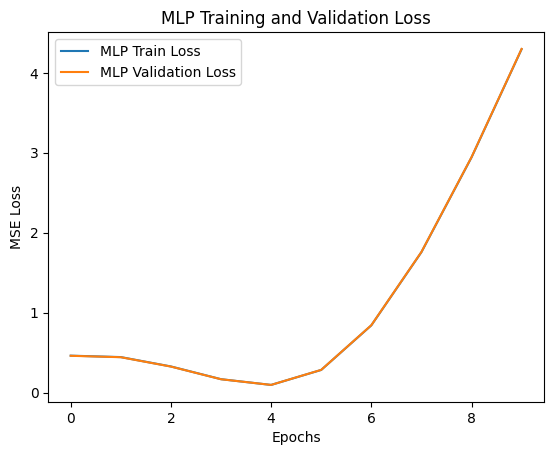

In [62]:
def mse_loss(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

mlp_loss_train = []
mlp_loss_val = []
for epoch in range(10):
    mlp.fit(X_train)
    
    A_train= mlp.get_latent(X_train)
    train_loss = np.mean(mse_loss(y_train, A_train))
    mlp_loss_train.append(train_loss)
    
    A_val = mlp.get_latent(X_val)
    val_loss = np.mean(mse_loss(y_val, A_val))
    mlp_loss_val.append(val_loss)

    print(f"Epoch [{epoch+1}/10], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


plt.plot(mlp_loss_train, label="MLP Train Loss")
plt.plot(mlp_loss_val, label="MLP Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("MLP Training and Validation Loss")
plt.show()


MLP has smaller loss than CNN, and also MLP is bit unststable than CNN

## 4.4.PCA Autoencoder

### 4.4.1.Implement the PcaAutoencoder Class

In [19]:
import sys
sys.path.append("../..")

import models.AutoEncoders.pca_autoencoder as pca_autoencoder

### 4.4.2.Estimate optimal number of components

In [16]:
import torch
import torch.nn.functional as F

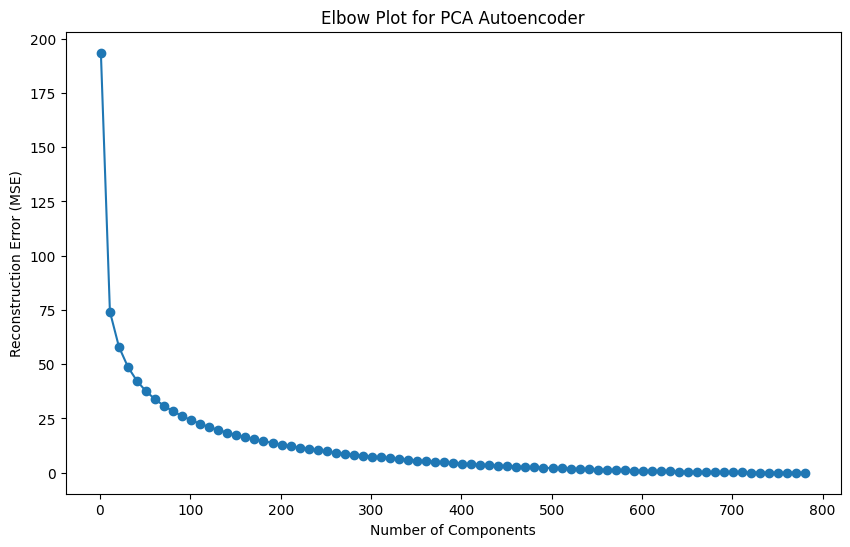

In [17]:
def calculate_mse_loss(autoencoder, data_loader):
    mse_loss = 0
    total_samples = 0
    for images, _ in data_loader:
        with torch.no_grad():
            reconstructed_images = autoencoder.forward(images)
            loss = F.mse_loss(reconstructed_images, images, reduction='sum')
            mse_loss += loss.item()
            total_samples += images.size(0)
    return mse_loss / total_samples

component_range = range(1, 784, 10)
errors = []

for n_components in component_range:
    autoencoder = pca_autoencoder.PcaAutoencoder(n_components=n_components)
    autoencoder.fit(train_loader)
    
    mse_loss = calculate_mse_loss(autoencoder, val_loader)
    errors.append(mse_loss)

plt.figure(figsize=(10, 6))
plt.plot(component_range, errors, marker='o', linestyle='-')
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error (MSE)")
plt.title("Elbow Plot for PCA Autoencoder")
plt.show()

from above plot elbow plot or k_optimal is 41

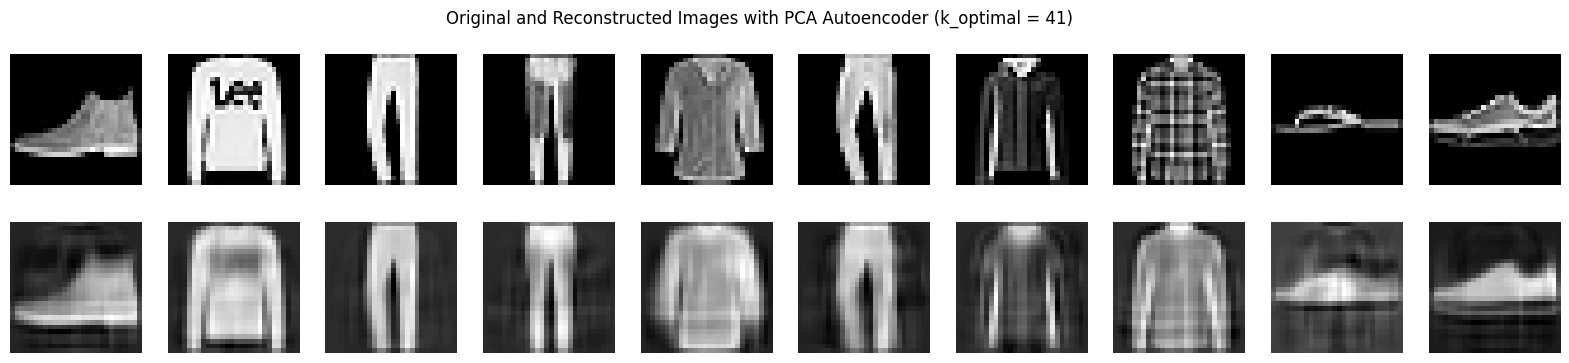

In [25]:
k_optimal = 41
optimal_autoencoder = pca_autoencoder.PcaAutoencoder(n_components=k_optimal)
optimal_autoencoder.fit(train_loader)

test_images, _ = next(iter(test_loader))
with torch.no_grad():
    reconstructed_images = optimal_autoencoder.forward(test_images)

n_images = 10
plt.figure(figsize=(20, 4))
for i in range(n_images):
    plt.subplot(2, n_images, i + 1)
    plt.imshow(test_images[i].view(28, 28), cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(reconstructed_images[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Original and Reconstructed Images with PCA Autoencoder (k_optimal = {k_optimal})")
plt.show()


Reconstructed images of PCA Autoencoder are close to actual images, when compared to CNN and MLP Autoencoders

## 4.5.KNN Classification

In [20]:
import numpy as np

In [21]:
cnn = cnn_autoencoder.CnnAutoencoder(latent_dim=41).to(device)
cnn.eval()
train_latent_cnn = []
for data in train_loader:
    inputs, _ = data
    inputs = inputs.to(device)
    features = cnn.encode(inputs)
    train_latent_cnn.append(features.cpu().detach().numpy())
train_latent_cnn = np.concatenate(train_latent_cnn, axis=0)

test_latent_cnn = []
for data in test_loader:
    inputs, _ = data
    inputs = inputs.to(device)
    features = cnn.encode(inputs)
    test_latent_cnn.append(features.cpu().detach().numpy())
test_latent_cnn = np.concatenate(test_latent_cnn, axis=0)

In [31]:
pca = pca_autoencoder.PcaAutoencoder(n_components=41)
pca.fit(train_loader)

train_latent_pca = []
for data in train_loader:
    inputs, _ = data
    features = pca.encode(inputs)
    train_latent_pca.append(features.numpy())
train_latent_pca = np.concatenate(train_latent_pca, axis=0)

test_latent_pca = []
for data in test_loader:
    inputs, _ = data
    features = pca.encode(inputs)
    test_latent_pca.append(features.detach().numpy())
test_latent_pca = np.concatenate(test_latent_pca, axis=0)

In [32]:
X_train, y_train = torch_to_numpy(train_loader)
X_test, y_test = torch_to_numpy(test_loader)

mlp = MLPautoencoder.AutoEncoder(learning_rate=0.0001,activation='sigmoid',optimizer='mini_batch',hidden_layers=2,neurons_per_layer=[128,32], latent_dim= 41,batch_size = 32,epochs=1,early_stopping = False,patience=0)

mlp.fit(X_train)
train_latent_mlp = mlp.get_latent(X_train).T
test_latent_mlp = mlp.get_latent(X_test).T


In [80]:
train_labels = np.argmax(y_train.T, axis=1)
test_labels = np.argmax(y_test.T, axis=1)

In [84]:
import sys
sys.path.append("../..")

import models.knn.knn as knn

In [92]:
cnn_test_accuracy = []

for k in range(1, 101, 10):
    model = knn.KNN(k=k, distance_type='euclidean')
    model.fit(train_latent_cnn, train_labels)
    test_prediction = model.predict(test_latent_cnn)
    test_accuracy = np.mean(test_prediction == test_labels)
    cnn_test_accuracy.append(test_accuracy)
    print(f"K: {k}, Test Accuracy: {test_accuracy:.4f}")

K: 1, Test Accuracy: 0.1006
K: 11, Test Accuracy: 0.0994
K: 21, Test Accuracy: 0.0962
K: 31, Test Accuracy: 0.0936
K: 41, Test Accuracy: 0.0939
K: 51, Test Accuracy: 0.0924
K: 61, Test Accuracy: 0.0919
K: 71, Test Accuracy: 0.0905
K: 81, Test Accuracy: 0.0888
K: 91, Test Accuracy: 0.0896


In [93]:
mlp_test_accuracy = []

for k in range(1, 101, 10):
    model = knn.KNN(k=k, distance_type='euclidean')
    model.fit(train_latent_mlp, train_labels)
    test_prediction = model.predict(test_latent_mlp)
    test_accuracy = np.mean(test_prediction == test_labels)
    mlp_test_accuracy.append(test_accuracy)
    print(f"K: {k}, Test Accuracy: {test_accuracy:.4f}")

K: 1, Test Accuracy: 0.7692
K: 11, Test Accuracy: 0.7968
K: 21, Test Accuracy: 0.7955
K: 31, Test Accuracy: 0.7880
K: 41, Test Accuracy: 0.7840
K: 51, Test Accuracy: 0.7819
K: 61, Test Accuracy: 0.7786
K: 71, Test Accuracy: 0.7769
K: 81, Test Accuracy: 0.7754
K: 91, Test Accuracy: 0.7709


In [94]:
pca_test_accuracy = []

for k in range(1, 101, 10):
    model = knn.KNN(k=k, distance_type='euclidean')
    model.fit(train_latent_pca, train_labels)
    test_prediction = model.predict(test_latent_pca)
    test_accuracy = np.mean(test_prediction == test_labels)
    pca_test_accuracy.append(test_accuracy)
    print(f"K: {k}, Test Accuracy: {test_accuracy:.4f}")

K: 1, Test Accuracy: 0.1042
K: 11, Test Accuracy: 0.0994
K: 21, Test Accuracy: 0.0942
K: 31, Test Accuracy: 0.0982
K: 41, Test Accuracy: 0.0979
K: 51, Test Accuracy: 0.1004
K: 61, Test Accuracy: 0.0952
K: 71, Test Accuracy: 0.0955
K: 81, Test Accuracy: 0.0971
K: 91, Test Accuracy: 0.0932


### 4.5.1.Performance Comparison

In [105]:
import numpy as np
import matplotlib.pyplot as plt

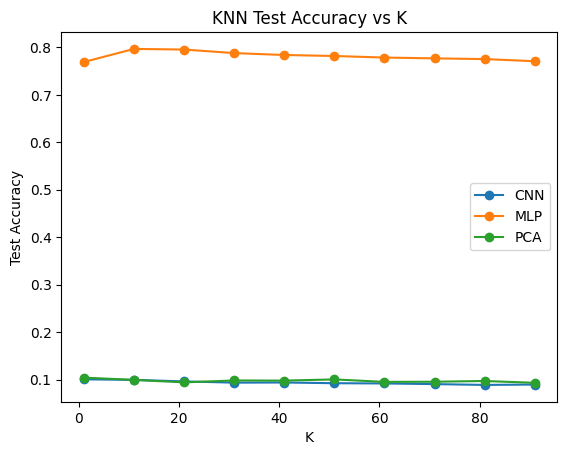

In [104]:
for test_accuracy, model_name in zip([cnn_test_accuracy, mlp_test_accuracy, pca_test_accuracy], ["CNN", "MLP", "PCA"]):
    plt.plot(range(1, 101, 10), test_accuracy, marker='o', label=model_name)

plt.xlabel("K")
plt.ylabel("Test Accuracy")
plt.title("KNN Test Accuracy vs K")
plt.legend()
plt.show()

models have maximum accuray at k=1 for CNN,PCA and K = 11 for MLP (models are tested only for k = 1,11,21,....)

In [106]:
def plot_confusion_matrix(actual_labels, predicted_labels):
    classes = np.unique(np.concatenate((actual_labels, predicted_labels)))
    num_classes = len(classes)
    
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    for actual, pred in zip(actual_labels, predicted_labels):
        conf_matrix[actual, pred] += 1

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')

    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

    plt.xticks(np.arange(num_classes), classes)
    plt.yticks(np.arange(num_classes), classes)
    plt.show()


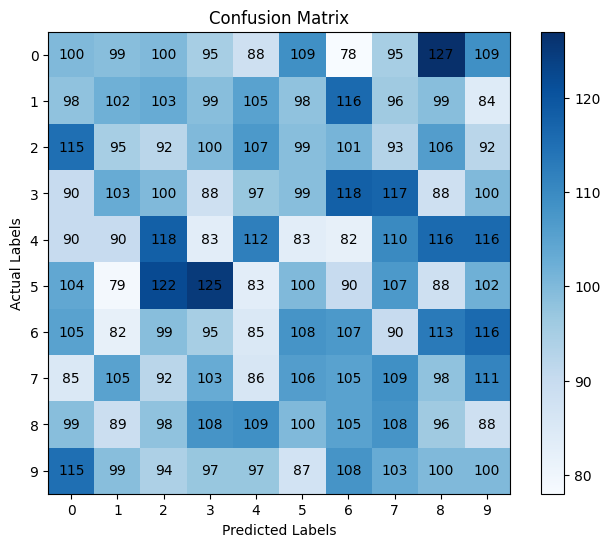

In [108]:
best_cnn_model = knn.KNN(k=1, distance_type='euclidean')
best_cnn_model.fit(train_latent_cnn, train_labels)
best_cnn_test_prediction = best_cnn_model.predict(test_latent_cnn)

plot_confusion_matrix(test_labels, best_cnn_test_prediction)

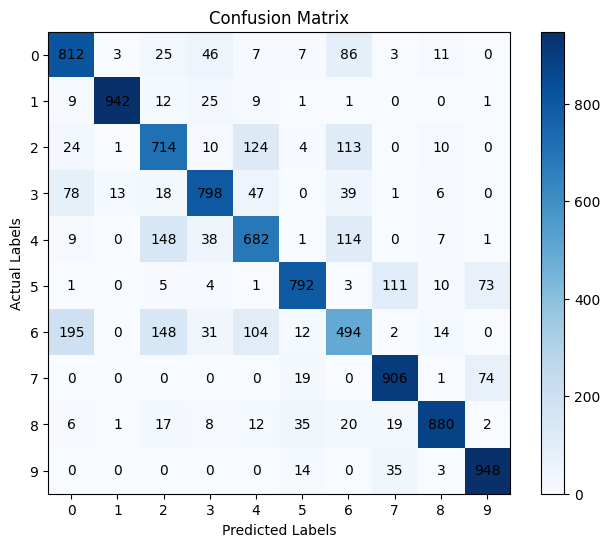

In [109]:
best_mlp_model = knn.KNN(k=11, distance_type='euclidean')
best_mlp_model.fit(train_latent_mlp, train_labels)
best_mlp_test_prediction = best_mlp_model.predict(test_latent_mlp)

plot_confusion_matrix(test_labels, best_mlp_test_prediction)

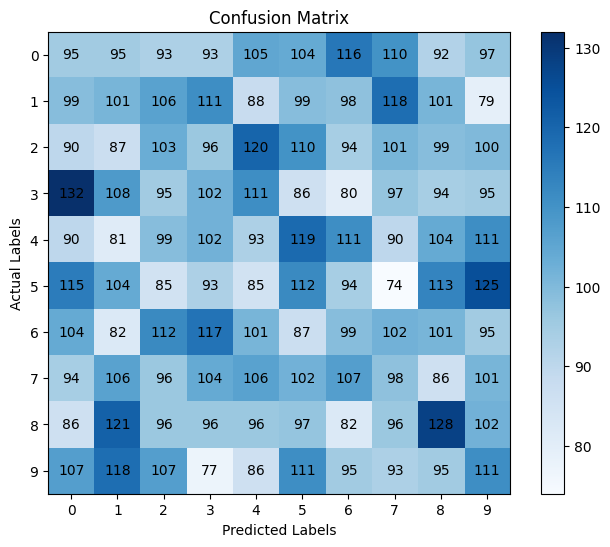

In [111]:
best_pca_model = knn.KNN(k=1, distance_type='euclidean')
best_pca_model.fit(train_latent_pca, train_labels)
best_pca_test_prediction = best_pca_model.predict(test_latent_pca)

plot_confusion_matrix(test_labels, best_pca_test_prediction)

In three confusion matrices (CNN, MLP, and PCA), MLP demonstrates substantially better classification with clear diagonal dominance, while CNN and PCA show more distributed confusion patterns. Classes 7 and 9 are relatively consistent between CNN and PCA, i.e these classes maintain similar confusion patterns with other classes and have comparable prediction distributions, showing neither particularly high accuracy nor poor performance.